<a href="https://colab.research.google.com/github/mrdobson/SENSIP_2021_REU/blob/main/jpnb/mnist_qnn_2class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install pylatexenc

     |████████████████████████████████| 6.0MB 4.2MB/s 
     |████████████████████████████████| 18.0MB 111kB/s 
     |████████████████████████████████| 235kB 38.8MB/s 
     |████████████████████████████████| 215kB 43.8MB/s 
     |████████████████████████████████| 2.1MB 26.8MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 1.5MB 32.3MB/s 
     |████████████████████████████████| 194kB 44.4MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 614kB 29.3MB/s 
     |████████████████████████████████| 3.2MB 38.4MB/s 
     |████████████████████████████████| 6.3MB 28.2MB/s 
  Created wheel for qiskit: filename=qiskit-0.27.0-cp37-none-any.whl size=10505 sha256=86bc8812ab4f3797d27059f02108e438981085b3fbce319702582d18867bf274
  Stored in directory: /root/.cache/pip/wheels/c6/54/d9/f0f711dc20aff31947456951374132d0e23ec527da8c15295d
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py

In [ ]:
# not all of these are critical, but to be safe just including everything for now
import numpy as np
import matplotlib.pyplot as plt
import time

from torch import tensor
from torch import cat, no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, CrossEntropyLoss,
                      MaxPool2d, Flatten, Sequential, ReLU)
import torch.optim as optim
import torch.nn.functional as F

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, ADAM

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

# Mode Parameters

In [ ]:
#qi = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024)
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

# modify these parameters to change which two characters we're going to
# compare against in the model
samp_val_1 = 1
samp_val_2 = 7

# MNIST Training Data Load

In [ ]:
# training set
n_samples = 210

# returns tuple with X_train.data and X_train.targets <-- what I don't have from iris
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# leave only labels samp_val_1 and samp_val_2
idx = np.append(np.where(X_train.targets == samp_val_1)[0][:n_samples],
                np.where(X_train.targets == samp_val_2)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# samp vals tunable above in the settings, this is to fit to our data loader
X_train.targets[X_train.targets==samp_val_1] = 0
X_train.targets[X_train.targets==samp_val_2] = 1
### DEBUG vnv that we remapped the correct samples 
#print("xtrain targets ", X_train.targets, "\n")

# perform training load
train_loader = DataLoader(X_train, batch_size=1, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# MNIST Test Data Load

In [ ]:
n_samples = 90

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))
# selecting which samples to keep (first 100 0s and 1s)
idx = np.append(np.where(X_test.targets == samp_val_1)[0][:n_samples], 
                np.where(X_test.targets == samp_val_2)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# samp vals tunable above in the settings, to fit to data loader
X_test.targets[X_test.targets==samp_val_1] = 0
X_test.targets[X_test.targets==samp_val_2] = 1
### DEBUG    
#print("xtest targets ", X_train.targets, "\n")

# perform testing load
test_loader = DataLoader(X_test, batch_size=1, shuffle=True)

# Define QNN

In [ ]:
num_inputs = 2

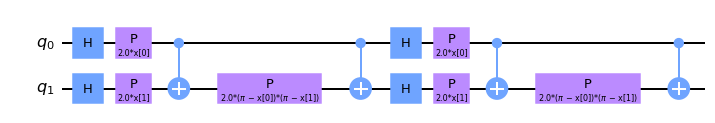

In [ ]:
# ZZ is 2nd order Pauli expansion circuit
fm = ZZFeatureMap(num_inputs)
fm.draw(output='mpl')

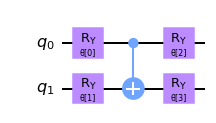

In [ ]:
# RealAmplitudes is used as an ansatz for ML, heuristic trial wave func
ansatz = RealAmplitudes(num_inputs, reps=1)
ansatz.draw(output='mpl')

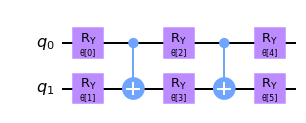

In [ ]:
ansatz2 = RealAmplitudes(num_inputs, reps=2)
ansatz2.draw(output='mpl')

In [ ]:
# define observable
observable = PauliSumOp.from_list([('Z'*num_inputs, 1)])
print(observable)

1.0 * ZZ


In [ ]:

# define two layer QNN
qnn = TwoLayerQNN(num_inputs, 
                  feature_map=fm, 
                  ansatz=ansatz, 
                  observable=observable,
                  quantum_instance=qi)
print(qnn.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌────────────────────┐┌──────────────────────────────┐
  q_0: ┤0                   ├┤0                             ├
       │  nlocal(x[0],x[1]) ││  nlocal(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                   ├┤1                             ├
       └────────────────────┘└──────────────────────────────┘
  )
])


In [ ]:
class Net(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)         # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  #
        self.fc3 = Linear(1, 1)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

model = Net()

In [ ]:
# define model, optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start Training

In [ ]:
epochs = 7    # set num epochs
loss_list = [] # store loss history
model.train()  # place model in training mode
for epoch in range(epochs):
    print('Starting epoch {} for 2 qubits'.format(epoch))
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True) # init gradient
        output = model(data)             # forward pass
        ### DEBUG
        #print("target is: ", target)
        #print("output is: ", output)
        loss = loss_func(output, target) # calc loss
        loss.backward()                  # backward pass
        optimizer.step()                 # optimize weights
        total_loss.append(loss.item())   # store loss
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:0f}%]\tLoss: {:.4f}'.format(
           100. * (epoch + 1) / epochs, loss_list[-1]))

Starting epoch 0 for 2 qubits
Training [14.285714%]	Loss: 0.7860
Starting epoch 1 for 2 qubits
Training [28.571429%]	Loss: 0.3856
Starting epoch 2 for 2 qubits
Training [42.857143%]	Loss: 0.2130
Starting epoch 3 for 2 qubits
Training [57.142857%]	Loss: 0.1444
Starting epoch 4 for 2 qubits
Training [71.428571%]	Loss: 0.0857
Starting epoch 5 for 2 qubits
Training [85.714286%]	Loss: 0.0685
Starting epoch 6 for 2 qubits
Training [100.000000%]	Loss: 0.0601


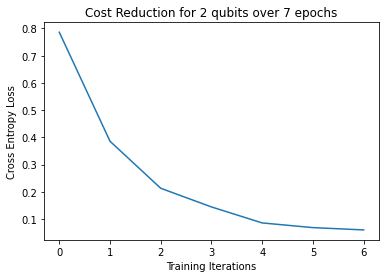

In [ ]:
# plot results of cost reduction
plt.figure(3)
plt.plot(loss_list)
plt.title('Cost Reduction for 2 qubits over {0} epochs'.format(epochs))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Perform Evaluations

In [ ]:
# start eval time
start_eval = time.time()

model.eval() # set into eval mode
with no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
            
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
    # batch_size goes where the 1 is here
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
           .format(sum(total_loss) / len(total_loss),
                correct / len(test_loader) / 1 * 100))
    
# end eval time
end_eval = time.time()
print('Evaluation time is: ', (end_eval - start_eval)/60, ' min')

Performance on test data:
	Loss: 0.0565
	Accuracy: 99.4%
Evaluation time is:  0.027743311723073323  min


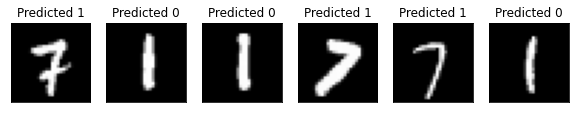

In [ ]:
# handful of examples for 2 qubit system
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        
        # remap class values to samp_val 1 and 2
        # where pred == 0 set it to samp_val_1, same for pred == 1
        # below lines don't work for this, need to figure out another way but not critical
        #pred.item[pred.item()==0] = samp_val_1
        #pred.item[pred.item()==1] = samp_val_2

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1